(a)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


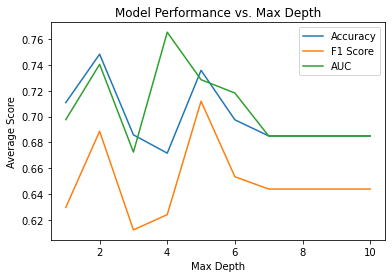

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

data = pd.read_csv('kindey stone urine analysis.csv')

X = data[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']]
y = data['target']

max_depths = list(range(1, 11))
avg_accuracy_scores = []
avg_f1_scores = []
avg_auc_scores = []

for max_depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    accuracy_scores = cross_val_score(dt_classifier, X, y, cv=5, scoring='accuracy')
    f1_scores = cross_val_score(dt_classifier, X, y, cv=5, scoring='f1')
    auc_scores = cross_val_score(dt_classifier, X, y, cv=5, scoring='roc_auc')

    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(auc_scores)

    avg_accuracy_scores.append(avg_accuracy)
    avg_f1_scores.append(avg_f1)
    avg_auc_scores.append(avg_auc)

plt.figure()
plt.plot(max_depths, avg_accuracy_scores, label='Accuracy')
plt.plot(max_depths, avg_f1_scores, label='F1 Score')
plt.plot(max_depths, avg_auc_scores, label='AUC')
plt.xlabel('Max Depth')
plt.ylabel('Average Score')
plt.title('Model Performance vs. Max Depth')
plt.legend()

plt.show()

I would choose depth 2 for the “final” model since at this depth all three scores are relatively high and the model is simple

(b)

Best Parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}


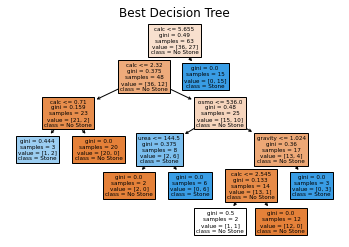

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'max_depth': list(range(1,10)),          
    'min_samples_split': [2, 5, 10],     
    'min_samples_leaf': [1, 2, 4]
}

dt_classifier = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train, y_train)

plt.figure()
plot_tree(best_dt_classifier, feature_names=X.columns, class_names=['No Stone', 'Stone'], filled=True)
plt.title("Best Decision Tree")
plt.show()

In [3]:
preds = best_dt_classifier.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, preds))
print("Baseline F1 Score:", f1_score(y_test, preds))
print("Baseline AUC Score:", roc_auc_score(y_test, preds))

Baseline Accuracy: 0.75
Baseline F1 Score: 0.75
Baseline AUC Score: 0.7619047619047621


(c)

In [4]:
import numpy as np
import pandas as pd
import json
import time
import random
import sys
import os  
from queue import Queue
import pathlib

from math import ceil
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics


# fit the tree using gradient boosted classifier
def fit_boosted_tree(X, y, n_est=10, lr=0.1, d=1):
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=lr, n_estimators=n_est, max_depth=d,
                                    random_state=42)
    clf.fit(X, y)
    out = clf.score(X, y)
    return clf, out


# perform cut on the dataset
def cut(X, ts):
    df = X.copy()
    colnames = X.columns
    for j in range(len(ts)):
        for s in range(len(ts[j])):
            X[colnames[j]+'<='+str(ts[j][s])] = 1
            k = df[colnames[j]] > ts[j][s]
            X.loc[k, colnames[j]+'<='+str(ts[j][s])] = 0
        X = X.drop(colnames[j], axis=1)
    return X


# compute the thresholds
def get_thresholds(X, y, n_est, lr, d, backselect=True):
    # got a complaint here...
    y = np.ravel(y)
    # X is a dataframe
    clf, out = fit_boosted_tree(X, y, n_est, lr, d)
    #print('acc:', out, 'acc cv:', score.mean())
    thresholds = []
    for j in range(X.shape[1]):
        tj = np.array([])
        for i in range(len(clf.estimators_)):
            f = clf.estimators_[i,0].tree_.feature
            t = clf.estimators_[i,0].tree_.threshold
            tj = np.append(tj, t[f==j])
        tj = np.unique(tj)
        thresholds.append(tj.tolist())

    X_new = cut(X, thresholds)
    clf1, out1 = fit_boosted_tree(X_new, y, n_est, lr, d)
    #print('acc','1:', out1, 'acc1 cv:', scorep.mean())

    outp = 1
    Xp = X_new.copy()
    clfp = clf1
    itr=0
    if backselect:
        while outp >= out1 and itr < X_new.shape[1]-1:
            vi = clfp.feature_importances_
            if vi.size > 0:
                c = Xp.columns
                i = np.argmin(vi)
                Xp = Xp.drop(c[i], axis=1)
                clfp, outp = fit_boosted_tree(Xp, y, n_est, lr, d)
                itr += 1
            else:
                break
        Xp[c[i]] = X_new[c[i]]
        #_, _ = fit_boosted_tree(Xp, y, n_est, lr, d)

    h = Xp.columns
    #print('features:', h)
    return Xp, thresholds, h

# compute the thresholds
def compute_thresholds(X, y, n_est=40, max_depth=10) :
    # n_est, max_depth: GBDT parameters
    # set LR to 0.1
    lr = 0.1
    start = time.perf_counter()
    X, thresholds, header = get_thresholds(X, y, n_est, lr, max_depth, backselect=True)
    guess_time = time.perf_counter()-start

    return X, thresholds, header, guess_time

In [5]:
from pydl85 import DL85Classifier
from itertools import product

df = pd.read_csv("kindey stone urine analysis.csv")
X, y = df.iloc[:,:-1].values, df.iloc[:,-1].values
h = df.columns[:-1]


X = pd.DataFrame(X, columns=h)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
def cross_validation(X, y, model, k_fold=5):
    scores = []
    X_folds = np.array_split(X, k_fold)
    y_folds = np.array_split(y, k_fold)
    for i in range(k_fold):
        X_val = X_folds[i]
        y_val = y_folds[i]
        X_train = np.concatenate([X_folds[j] for j in \
                      range(k_fold) if j != i])
        y_train = np.concatenate([y_folds[j] for j in \
                      range(k_fold) if j != i])
        X_train = pd.DataFrame(X_train, columns=h)
        X_val = pd.DataFrame(X_val, columns=h)
        X_train, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train)
        X_val = cut(X_val, thresholds)
        X_val = X_val[header]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        scores.append(f1_score(y_val, preds)) 
    return np.mean(scores)
param_grid = {
    'max_depth': list(range(1,10)),
}
best_f1 = 0
best_params = None
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    clf = DL85Classifier(**param_dict)
    f1=cross_validation(X_train, y_train,clf)
    print(f"Parameters: {param_dict}, Average F1: {f1:.4f}")   
    if f1 > best_f1:
            best_f1 = f1
            best_params = param_dict      
            
print(f"Best Parameters: {best_params}, Best Average F1: {best_f1:.4f}")    

Parameters: {'max_depth': 1}, Average F1: 0.6733
Parameters: {'max_depth': 2}, Average F1: 0.6434
Parameters: {'max_depth': 3}, Average F1: 0.6533
Parameters: {'max_depth': 4}, Average F1: 0.6261
Parameters: {'max_depth': 5}, Average F1: 0.6667
Parameters: {'max_depth': 6}, Average F1: 0.6667
Parameters: {'max_depth': 7}, Average F1: 0.7313
Parameters: {'max_depth': 8}, Average F1: 0.7313
Parameters: {'max_depth': 9}, Average F1: 0.7313
Best Parameters: {'max_depth': 7}, Best Average F1: 0.7313


In [6]:
X_train_guess, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train)
X_test_guess = cut(X_test, thresholds)
X_test_guess = X_test_guess[header]
best_DL85_classifier = DL85Classifier(**best_params)
best_DL85_classifier.fit(X_train_guess, y_train)

preds = best_DL85_classifier.predict(X_test_guess)

baseline_f1 = f1_score(y_test, preds)
baseline_auc = roc_auc_score(y_test, preds)

print("accuracy on the test dataset:", accuracy_score(y_test, preds))
print("F1 Score on the test dataset:", f1_score(y_test, preds))
print("AUC Score on the test dataset:", roc_auc_score(y_test, preds))

accuracy on the test dataset: 0.75
F1 Score on the test dataset: 0.7142857142857143
AUC Score on the test dataset: 0.746031746031746


(d)

For this dataset, They perform similarly but traditional decision tree performs slightly better because this dataset is simple and does not require advanced modeling.